In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os

for dirname, _, filenames in os.walk('../data/raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/raw/sales_test.csv
../data/raw/.DS_Store
../data/raw/solution.csv
../data/raw/sales_train.csv
../data/raw/calendar.csv
../data/raw/test_weights.csv
../data/raw/inventory.csv


In [24]:
calendar = pd.read_csv('../data/raw/calendar.csv')
test_weights = pd.read_csv('../data/raw/test_weights.csv')
inventory = pd.read_csv('../data/raw/inventory.csv')
sales_train = pd.read_csv('../data/raw/sales_train.csv')
sales_test = pd.read_csv('../data/raw/sales_test.csv')
solution = pd.read_csv('../data/raw/solution.csv')

In [25]:
def combine_sales_data(target_df, inventory_df, calendar_df):
    """
    Combines sales data (target_df) with inventory and calendar data, modifying the target_df in place.
    
    Parameters:
    target_df (pd.DataFrame): The sales data (either from sales_train or sales_test), which will be modified.
    inventory_df (pd.DataFrame): The inventory data containing product details.
    calendar_df (pd.DataFrame): The calendar data containing information about holidays and events.
    """

    target_df = target_df.merge(inventory_df[['unique_id', 'product_unique_id', 'name', 
                                  'L1_category_name_en', 'L2_category_name_en', 
                                  'L3_category_name_en', 'L4_category_name_en']], 
                    on='unique_id', how='left')

    target_df = target_df.merge(calendar_df[['date', 'warehouse', 'holiday', 'holiday_name', 
                                 'shops_closed', 'winter_school_holidays', 'school_holidays']], 
                    on=['date', 'warehouse'], how='left')

    return target_df



In [26]:
sales_train = combine_sales_data(sales_train, inventory, calendar)
sales_test = combine_sales_data(sales_test, inventory, calendar)
sales_train['date'] = pd.to_datetime(sales_train['date'])
sales_test['date'] = pd.to_datetime(sales_test['date'])

In [27]:
sales_train.drop(['name', 'holiday_name'], axis=1, inplace=True)

sales_train['month'] = sales_train['date'].dt.month
sales_train['weekday'] = sales_train['date'].dt.weekday
sales_train['year'] = sales_train['date'].dt.year
sales_train['week_of_year'] = sales_train['date'].dt.isocalendar().week  # Week number of the year
sales_train['day_of_year'] = sales_train['date'].dt.dayofyear  # Day number of the year
sales_train['is_weekend'] = (sales_train['weekday'] >= 5).astype(int)  # 1 if Sat/Sun, else 0
sales_train['quarter'] = sales_train['date'].dt.quarter  # Quarter of the year
sales_train['is_month_start'] = sales_train['date'].dt.is_month_start.astype(int)  # 1 if first day of month
sales_train['is_month_end'] = sales_train['date'].dt.is_month_end.astype(int)  # 1 if last day of month



sales_train['unique_date'] = sales_train['unique_id'].astype(str) + '_' + sales_train['date'].astype(str)

sales_train.set_index('unique_date', inplace=True)

sales_train.drop(['date', 'product_unique_id', 'availability'], axis=1, inplace=True)
sales_train.dropna(inplace=True)

In [28]:
# Optimized lags
lags = [1, 2, 7, 365]
for lag in lags:
    sales_train[f'lag_{lag}'] = sales_train.groupby('unique_id')['sales'].shift(lag)

# Optimized rolling mean
windows = [7, 14, 28, 60, 365]  # Removed 180
for window in windows:
    sales_train[f'rolling_mean_{window}'] = sales_train.groupby('unique_id')['sales'].transform(lambda x: x.rolling(window).mean())

# Optimized rolling std
for window in windows:
    sales_train[f'rolling_std_{window}'] = sales_train.groupby('unique_id')['sales'].transform(lambda x: x.rolling(window).std())

# fillna
sales_train.fillna(0, inplace=True)


In [29]:
# group type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount to one column
sales_train['discount'] = sales_train['type_0_discount'] + sales_train['type_1_discount'] + sales_train['type_2_discount'] + sales_train['type_3_discount'] + sales_train['type_4_discount'] + sales_train['type_5_discount'] + sales_train['type_6_discount']

sales_train.drop(['type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount'], axis=1, inplace=True)

In [30]:
# Identifier les variables numériques
numerical_cols = sales_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != 'sales']

# Identifier les cardinalités des variables catégorielles
cardinalities = {col: sales_train[col].nunique() for col in sales_train.select_dtypes(include=['object','category']).columns}

# Séparer les colonnes catégorielles selon leur cardinalité
low_cardinality_cols = [col for col, card in cardinalities.items() if card <= 10]
high_cardinality_cols = [col for col, card in cardinalities.items() if 10 < card ]

print(f'Numerical columns: {numerical_cols}')
print(f'Low cardinality columns: {low_cardinality_cols}')
print(f'High cardinality columns: {high_cardinality_cols}')

Numerical columns: ['unique_id', 'total_orders', 'sell_price_main', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'is_weekend', 'is_month_start', 'is_month_end', 'lag_1', 'lag_2', 'lag_7', 'lag_365', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28', 'rolling_mean_60', 'rolling_mean_365', 'rolling_std_7', 'rolling_std_14', 'rolling_std_28', 'rolling_std_60', 'rolling_std_365', 'discount']
Low cardinality columns: ['warehouse', 'L1_category_name_en']
High cardinality columns: ['L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en']


In [31]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

target = 'sales'

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data for target encoding
categorical_transformer_target = ce.TargetEncoder()

# Preprocessing for categorical data for one-hot encoding
categorical_transformer_one_hot = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat_target', categorical_transformer_target, high_cardinality_cols),
        ('cat_onehot', categorical_transformer_one_hot, low_cardinality_cols)
    ]
)

In [32]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=200, 
    max_depth=9, 
    learning_rate=0.15,  # Rounded for simplicity
    subsample=1, 
    colsample_bytree=0.75, 
    gamma=2.5, 
    reg_alpha=0, 
    reg_lambda=100
)

# Create and configure the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# Séparer les données en entraînement et test
X = sales_train.drop('sales', axis=1)  
y = sales_train['sales']  

# Diviser en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cross-validation
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Custom scores for each fold:", -scores)
print("Average custom score:", np.sqrt(np.mean(-scores)))

# Train the model on the entire dataset
pipeline.fit(X_train, y_train)


Custom scores for each fold: [4719.93201308 4810.95810406 5025.90430601 5388.93850573 4755.57157764]
Average custom score: 70.28698955925596


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['unique_id', 'total_orders',
                                                   'sell_price_main', 'holiday',
                                                   'shops_closed',
                                                   'winter_school_holidays',
                                                   'school_holidays',
                                                   'is_weekend',
                                                   'is_month_start',
                                                   'is_month_end', 'lag_1',
                                                   'lag_2', 'lag_7', 'lag_365',
                                                   'rolling_mean_7',
                                                   'rolling_mean_14',
                                                   'rolling_mean_28',
                                                   'rolling_mean_60...
                              feature_types=None, gamma=2.5, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.15,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [33]:
# Faire des prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Calculer la MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 25.751883950786123


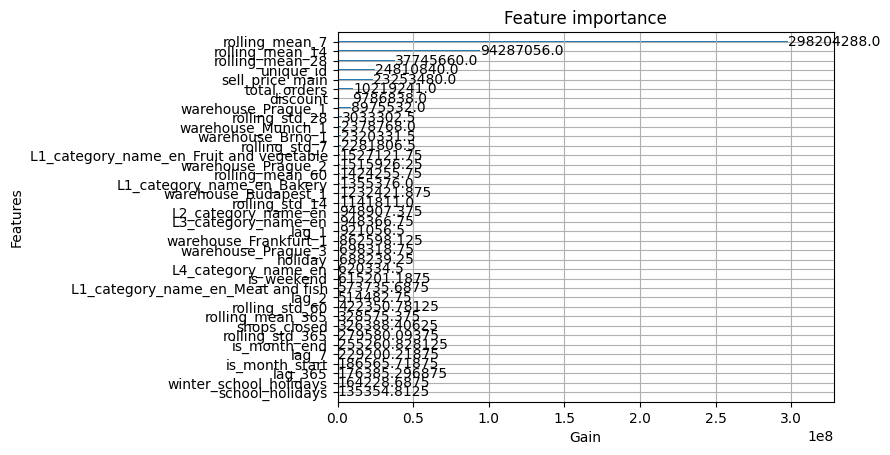

In [34]:
one_hot_feature_names = []
for feature, categories in zip(low_cardinality_cols, 
                               pipeline.named_steps['preprocessor'].named_transformers_['cat_onehot'].categories_):
    one_hot_feature_names.extend([f"{feature}_{category}" for category in categories])

features = numerical_cols + high_cardinality_cols + one_hot_feature_names

# Set feature names in the XGBoost model
pipeline.named_steps['model'].get_booster().feature_names = features

# Plot feature importance
xgb.plot_importance(pipeline.named_steps['model'], importance_type='gain', xlabel='Gain')
plt.show()